In [1]:
ACT_DIR = "/home/can/dynamic_representations/artifacts/activations/20251009_120036"

In [2]:
import json
import os
import torch as th

path = os.path.join(ACT_DIR, "temporal", "pred_codes.pt")
with open(path, "rb") as f:
    pred_BLD = th.load(f, weights_only=False)

path = os.path.join(ACT_DIR, "temporal", "novel_codes.pt")
with open(path, "rb") as f:
    novel_BLD = th.load(f, weights_only=False)

path = os.path.join(ACT_DIR, "tokens.pt")
with open(path, "rb") as f:
    tokens_BL = th.load(f, weights_only=False)

path = os.path.join(ACT_DIR, "masks.pt")
with open(path, "rb") as f:
    masks_BL = th.load(f, weights_only=False)

path = os.path.join(ACT_DIR, "config.json")
with open(path, "r") as f:
    cfg = json.load(f)

In [19]:
from src.exp_utils import load_tokens_of_single_story

story_idx = 0

pred_LD = pred_BLD[story_idx]
novel_LD = novel_BLD[story_idx]
tokens_L = tokens_BL[story_idx]
mask_L = masks_BL[story_idx].bool()

pred_LD = pred_LD[mask_L]
novel_LD = novel_LD[mask_L]
tokens_L = tokens_L[mask_L]

token_str_L = load_tokens_of_single_story(
    tokens_L,
    model_name=cfg["llm"]["hf_name"]
)

"".join(token_str_L)



"<bos>Once upon a time, a little girl named Alice loved looking at the night sky. 'I wish I could count all the stars!' Alice said to her best friend Maya. The two girls stood on a big grass field as the moon rose from the trees. Suddenly, Maya had a striking idea. She opened her laptop and started typing:\n```python\narray = []\nfor i in range(1, 6):\n    s = int(input(f'num_stars:'))\n    array.append(s)\ntot = sum(array)\navg = tot / len(array)\nprint(f'Avg / night: {avg:.1f}')"

In [20]:
# from src.model_utils import load_sae
# from dataclasses import dataclass
# from src.configs import SAEConfig, EnvironmentConfig

# @dataclass
# class DataClass:
#     sae = SAEConfig(
#         name="temporal",
#         local_weights_path="/home/can/dynamic_representations/artifacts/trained_saes/selftrain/temporal",
#         dict_class="temporal",
#         dict_size=9216,  # 2304 * 4 (exp_factor)
#         batch_size=10,
#     )
#     env = EnvironmentConfig(
#         device="cuda",
#         dtype="bfloat16",
#         hf_cache_dir="/home/can/models",
#         plots_dir="/home/can/dynamic_representations/artifacts/plots",
#         results_dir="/home/can/dynamic_representations/artifacts/results",
#         text_inputs_dir="/home/can/dynamic_representations/artifacts/text_inputs",
#         activations_dir="/home/can/dynamic_representations/artifacts/activations",
#     )


# sae = load_sae(DataClass())
# dec_SD = sae.D
# dec_SD.shape

In [21]:
nonzero_LD = pred_LD[4].nonzero()
nonzero_LD.shape

torch.Size([2796, 1])

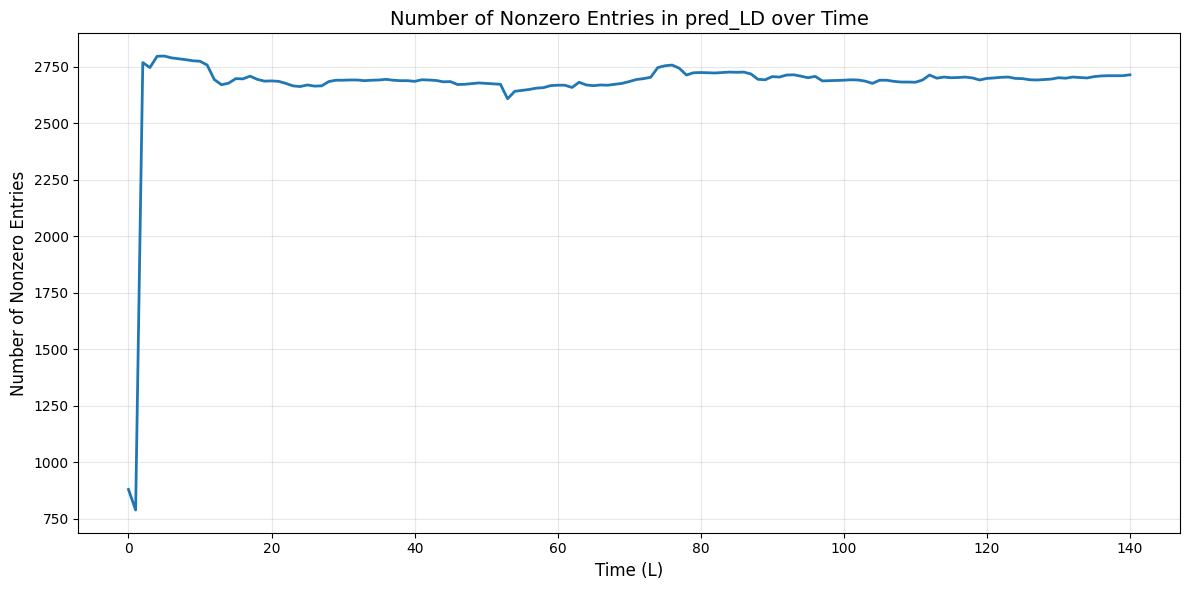

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# Count nonzero entries for each time step
L = pred_LD.shape[0]
nonzero_counts = [(pred_LD[t] != 0).sum().item() for t in range(L)]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(range(L), nonzero_counts, linewidth=2)
plt.xlabel('Time (L)', fontsize=12)
plt.ylabel('Number of Nonzero Entries', fontsize=12)
plt.title('Number of Nonzero Entries in pred_LD over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

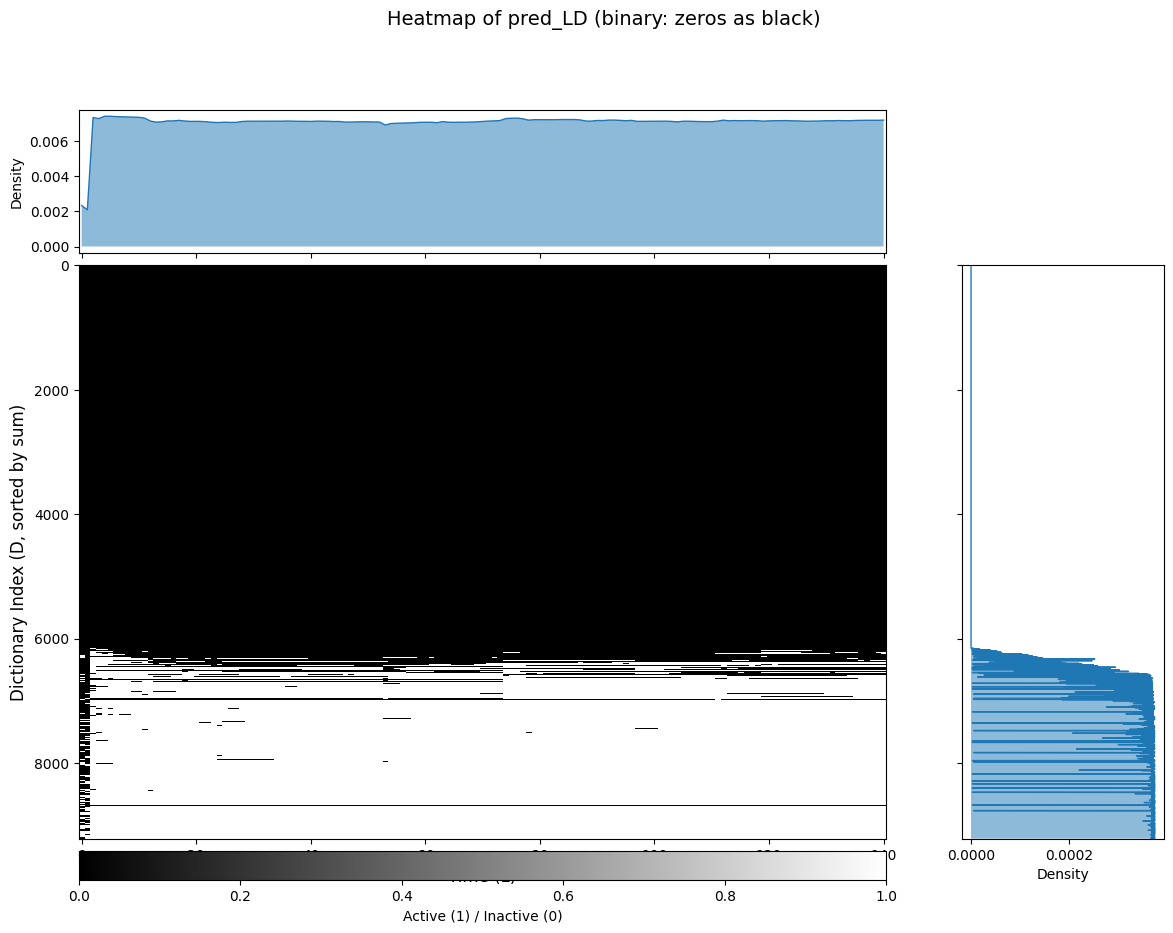

In [23]:
# Heatmap of pred_LD with zeros as black (binary plot) with marginal density plots
# Sort D by sum over L
sum_over_L = pred_LD.sum(dim=0)
sorted_indices = th.argsort(sum_over_L, descending=True)
pred_LD_sorted = pred_LD[:, sorted_indices]

pred_LD_plot = (pred_LD_sorted != 0).cpu().float().numpy()

# Calculate densities (normalized sums)
density_time = pred_LD_plot.sum(axis=1) / pred_LD_plot.sum()  # Sum over features, normalize
density_features = pred_LD_plot.sum(axis=0) / pred_LD_plot.sum()  # Sum over time, normalize

# Create figure with subplots
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 4, 0.2], width_ratios=[4, 0.2, 1], 
                      hspace=0.05, wspace=0.05)

# Main heatmap
ax_main = fig.add_subplot(gs[1, 0])
im = ax_main.imshow(pred_LD_plot.T, aspect='auto', cmap='binary_r', interpolation='nearest')
ax_main.set_xlabel('Time (L)', fontsize=12)
ax_main.set_ylabel('Dictionary Index (D, sorted by sum)', fontsize=12)

# Top marginal (density over time)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.fill_between(range(len(density_time)), density_time, alpha=0.5)
ax_top.plot(range(len(density_time)), density_time, linewidth=1)
ax_top.set_ylabel('Density', fontsize=10)
ax_top.tick_params(labelbottom=False)

# Right marginal (density over features)
ax_right = fig.add_subplot(gs[1, 2], sharey=ax_main)
ax_right.fill_betweenx(range(len(density_features)), density_features, alpha=0.5)
ax_right.plot(density_features, range(len(density_features)), linewidth=1)
ax_right.set_xlabel('Density', fontsize=10)
ax_right.tick_params(labelleft=False)

# Colorbar
ax_cbar = fig.add_subplot(gs[2, 0])
plt.colorbar(im, cax=ax_cbar, orientation='horizontal', label='Active (1) / Inactive (0)')

fig.suptitle('Heatmap of pred_LD (binary: zeros as black)', fontsize=14, y=0.98)
plt.show()

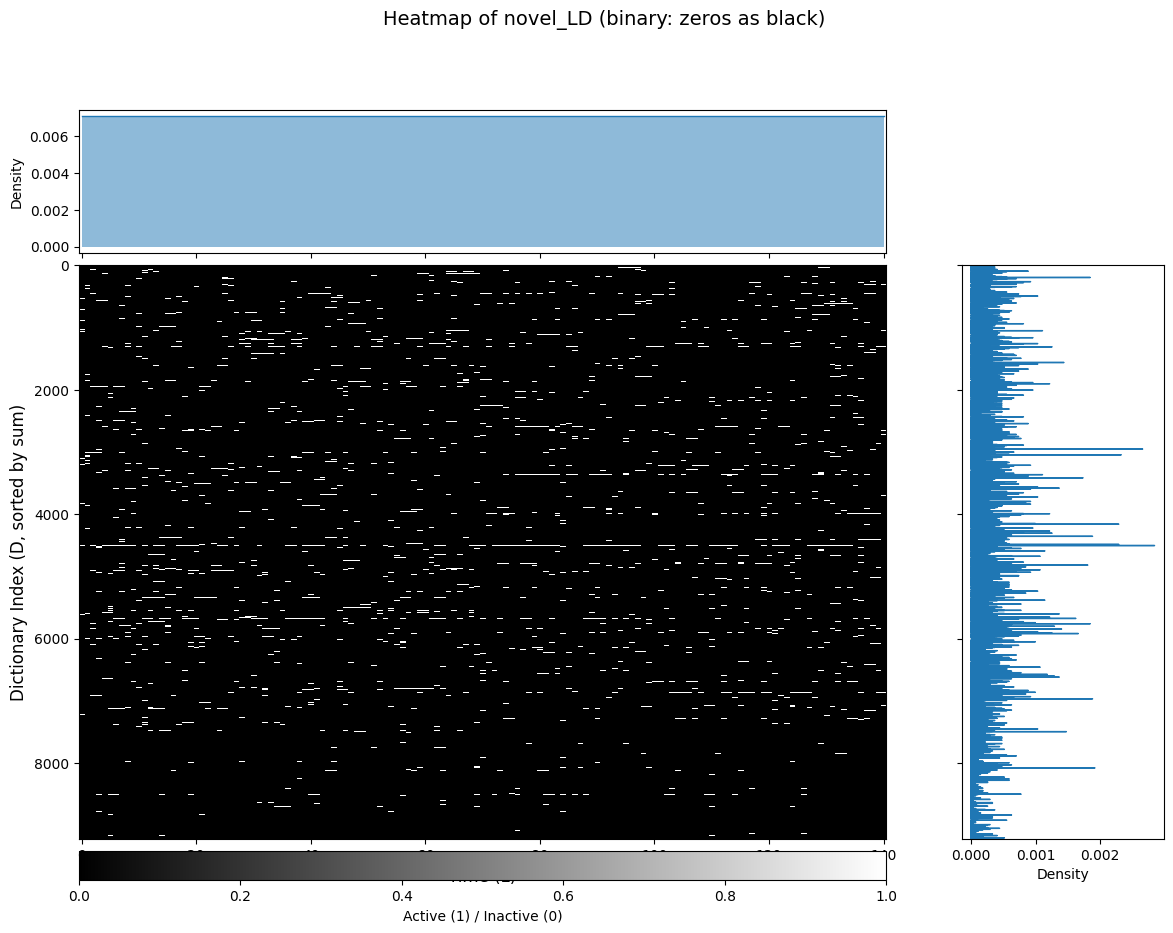

In [24]:
# Heatmap of novel_LD with zeros as black (binary plot) with marginal density plots
# Use the same sorting as pred_LD
novel_LD_sorted = novel_LD[:, sorted_indices]

novel_LD_plot = (novel_LD_sorted != 0).cpu().float().numpy()

# Calculate densities (normalized sums)
density_time_novel = novel_LD_plot.sum(axis=1) / novel_LD_plot.sum()  # Sum over features, normalize
density_features_novel = novel_LD_plot.sum(axis=0) / novel_LD_plot.sum()  # Sum over time, normalize

# Create figure with subplots
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 4, 0.2], width_ratios=[4, 0.2, 1], 
                      hspace=0.05, wspace=0.05)

# Main heatmap
ax_main = fig.add_subplot(gs[1, 0])
im = ax_main.imshow(novel_LD_plot.T, aspect='auto', cmap='binary_r', interpolation='nearest')
ax_main.set_xlabel('Time (L)', fontsize=12)
ax_main.set_ylabel('Dictionary Index (D, sorted by sum)', fontsize=12)

# Top marginal (density over time)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.fill_between(range(len(density_time_novel)), density_time_novel, alpha=0.5)
ax_top.plot(range(len(density_time_novel)), density_time_novel, linewidth=1)
ax_top.set_ylabel('Density', fontsize=10)
ax_top.tick_params(labelbottom=False)

# Right marginal (density over features)
ax_right = fig.add_subplot(gs[1, 2], sharey=ax_main)
ax_right.fill_betweenx(range(len(density_features_novel)), density_features_novel, alpha=0.5)
ax_right.plot(density_features_novel, range(len(density_features_novel)), linewidth=1)
ax_right.set_xlabel('Density', fontsize=10)
ax_right.tick_params(labelleft=False)

# Colorbar
ax_cbar = fig.add_subplot(gs[2, 0])
plt.colorbar(im, cax=ax_cbar, orientation='horizontal', label='Active (1) / Inactive (0)')

fig.suptitle('Heatmap of novel_LD (binary: zeros as black)', fontsize=14, y=0.98)
plt.show()

In [25]:
pred_LD.shape

torch.Size([141, 9216])

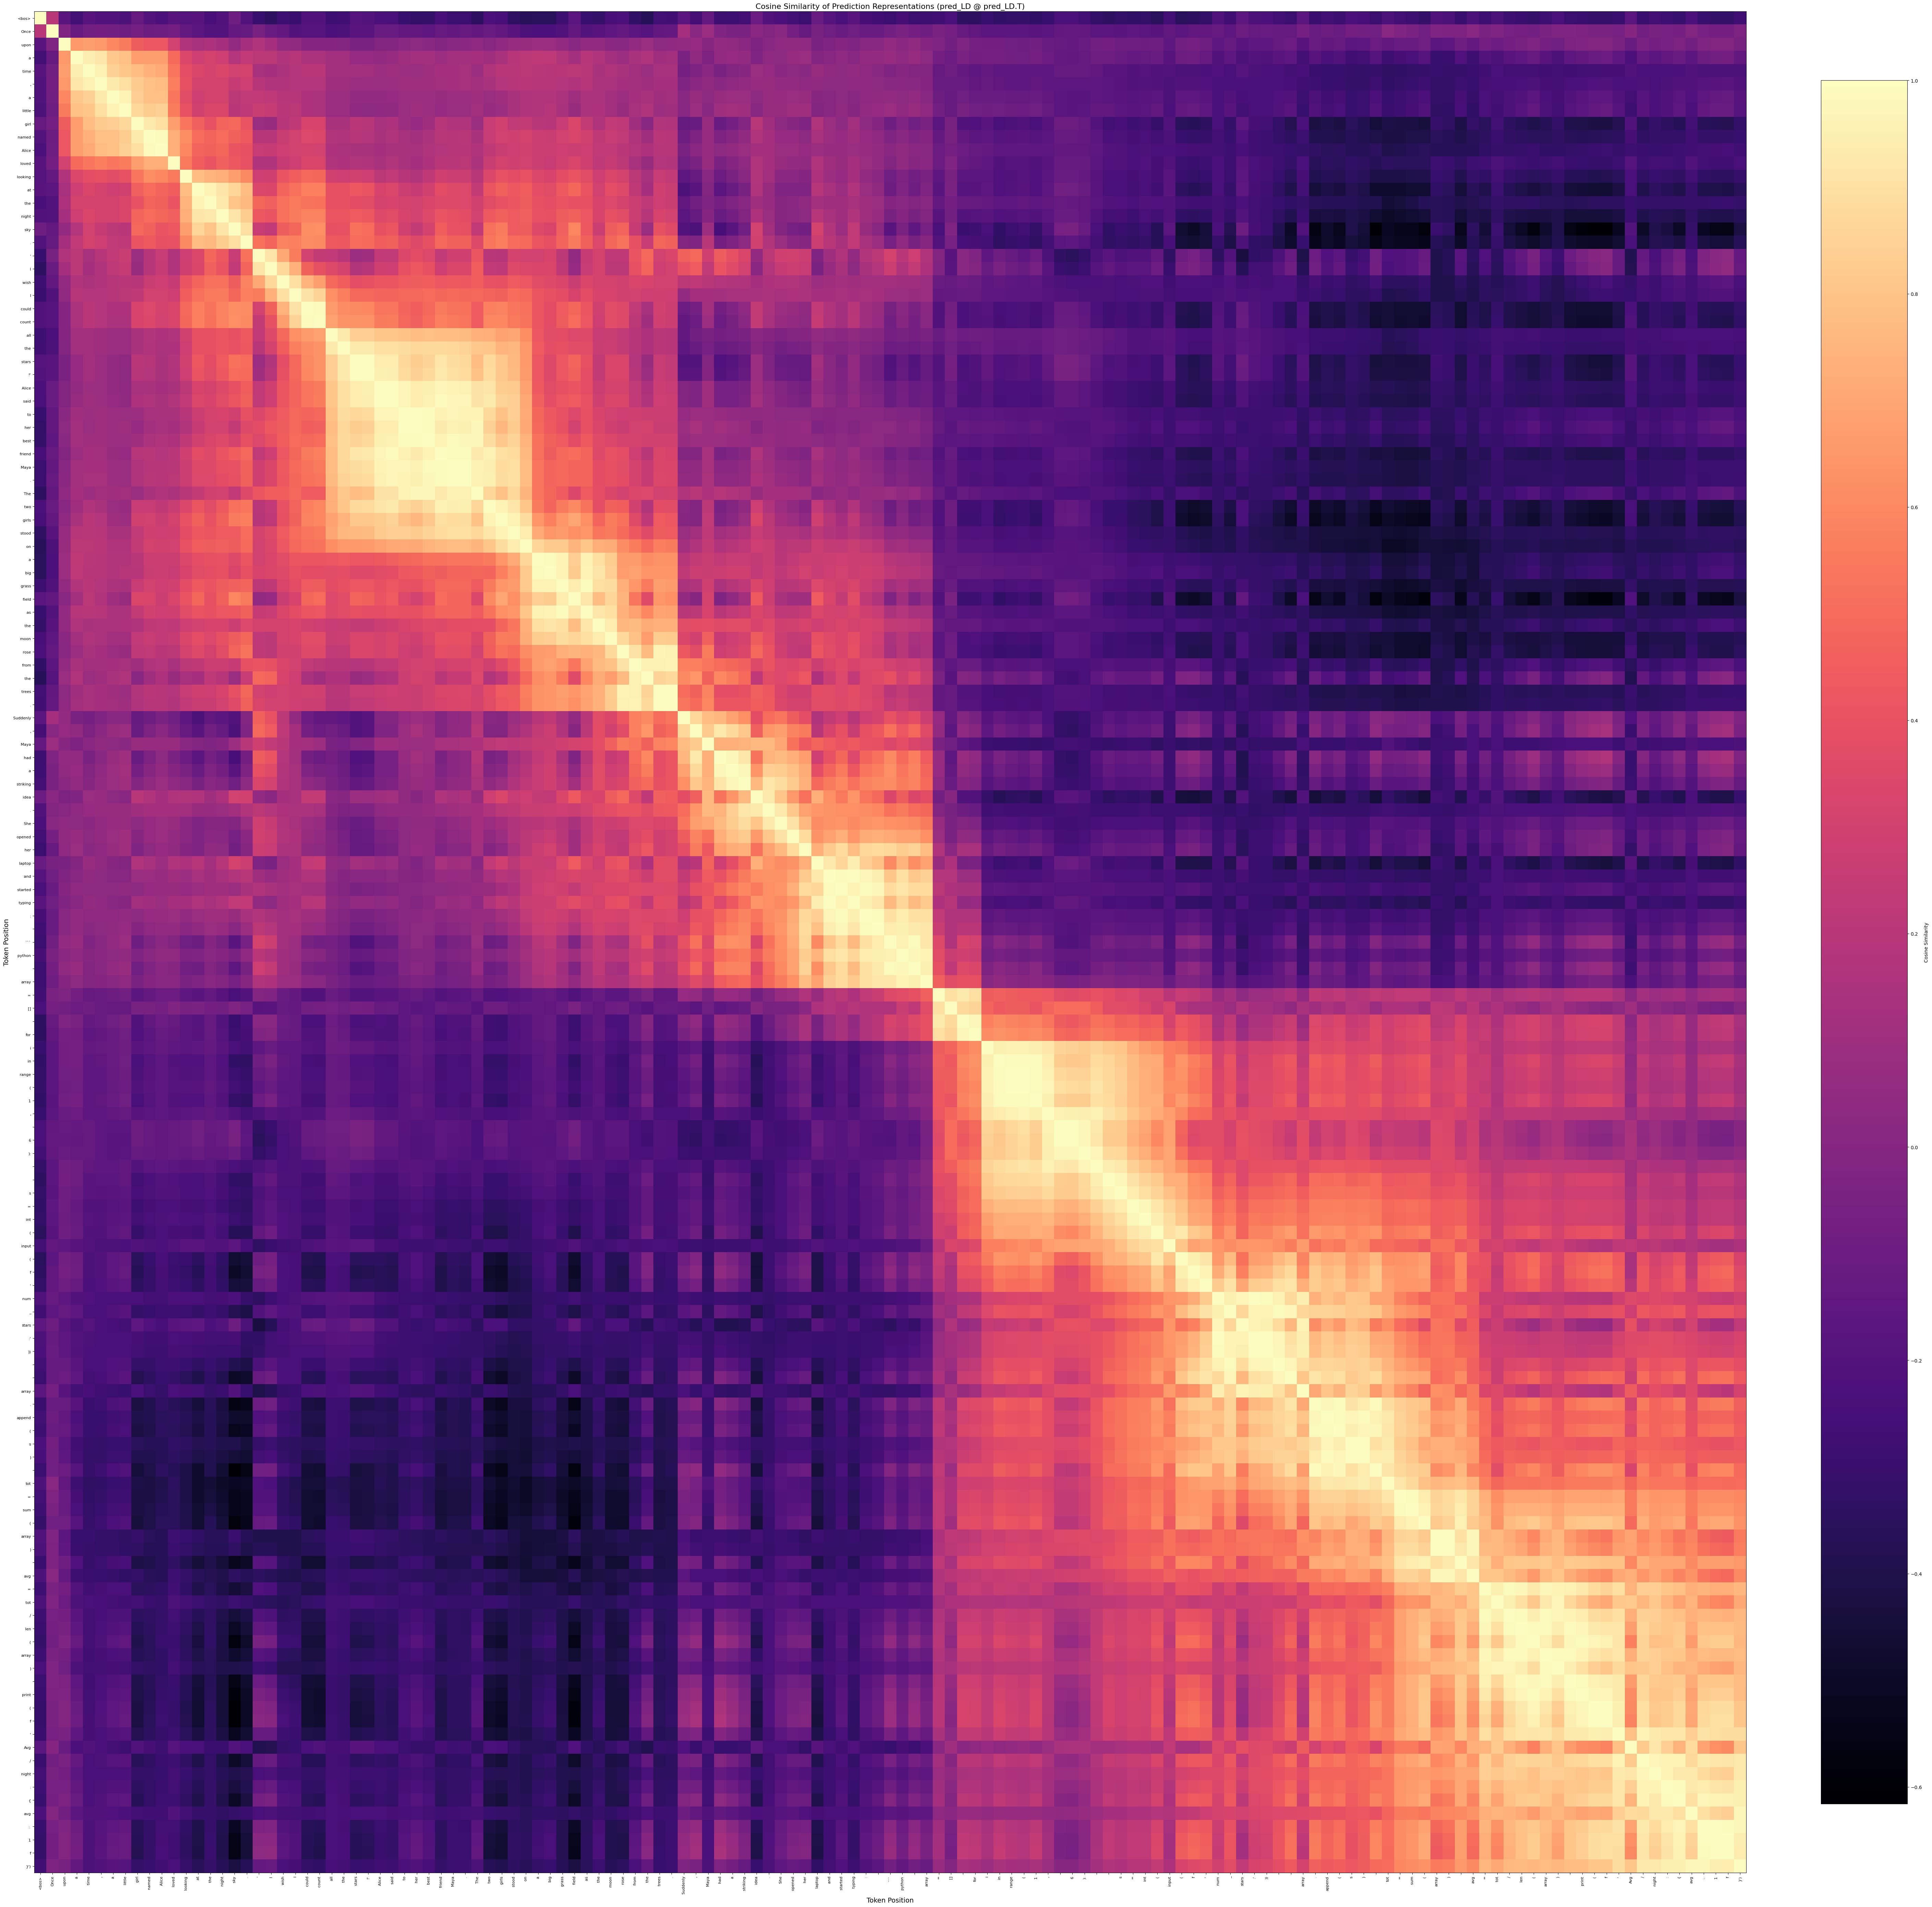

In [26]:
import torch.nn.functional as F

vmin = None
vmax = None

# Compute cosine similarity matrix
# pred_LD: shape (L, D)
# Normalize along D dimension
pred_centered_LD = pred_LD - th.mean(pred_LD, dim=0, keepdim=True)
pred_LD_normalized = F.normalize(pred_centered_LD.float(), p=2, dim=-1)  # L x D, normalized along D

# Compute cosine similarity: pred_LD @ pred_LD.T -> L x L
cosine_sim_LL = pred_LD_normalized @ pred_LD_normalized.T

# Convert to numpy for plotting
cosine_sim_np = cosine_sim_LL.cpu().numpy()

# Create a large figure to accommodate token labels
L = len(token_str_L)
fig, ax = plt.subplots(figsize=(max(20, L * 0.5), max(18, L * 0.5)))

# Plot heatmap
im = ax.imshow(cosine_sim_np, cmap='magma', aspect='auto', vmin=vmin, vmax=vmax)

# Set tick labels to tokens
ax.set_xticks(range(L))
ax.set_yticks(range(L))
ax.set_xticklabels(token_str_L, rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(token_str_L, fontsize=8)

# Labels and title
ax.set_xlabel('Token Position', fontsize=14)
ax.set_ylabel('Token Position', fontsize=14)
ax.set_title('Cosine Similarity of Prediction Representations (pred_LD @ pred_LD.T)', fontsize=16)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Cosine Similarity')

# plt.tight_layout()
plt.show()